In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
data = datasets.load_iris()
#create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = pd.DataFrame(data.target)
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [12]:
np.array(df[df['Target'] == 0].iloc[:,[0,1]].head())

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6]])

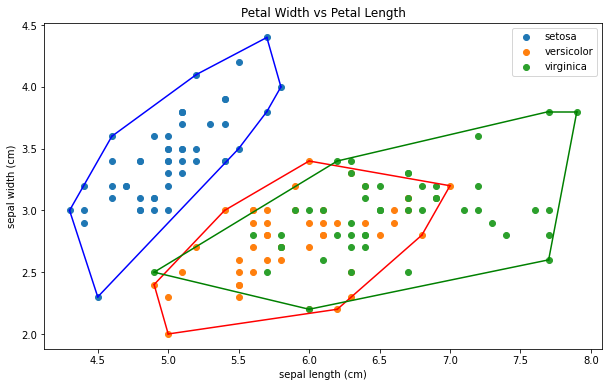

In [13]:
from scipy.spatial import ConvexHull
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i]
    bucket = bucket.iloc[:,[0,1]].values
    hull = ConvexHull(bucket) #bagian ini diganti dengan hasil implementasi ConvexHull Divide & Conquer
    plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
    for simplex in hull.simplices:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.legend()
plt.show()

In [14]:
hull.simplices

array([[19,  6],
       [18, 31],
       [18, 19],
       [48,  6],
       [17, 31],
       [17, 48]], dtype=int32)

In [15]:
def is_upper_left(p1, p2, p3):
    # Fix order
    if (p1[0] == p2[0]) and (p1[1] > p2[1]):
        tmp = p1
        p1 = p2
        p2 = tmp

    det = (p1[0] * p2[1]) + (p3[0] * p1[1]) + (p2[0] * p3[1]) - (p3[0] * p2[1]) - (p2[0] * p1[1]) - (p1[0] * p3[1])

    return (det > 0)

def norm(p1, p3):
    return ((p3[0] - p1[0])**2 + (p3[1] - p1[1])**2)**0.5

def compute_cosine(p1, p2, p3):
    dot = (p3[0] - p1[0]) * (p3[0] - p2[0]) + (p3[1] - p1[1]) * (p3[1] - p2[1])
    norms = norm(p1, p3) * norm(p2, p3) # VEKTOR AC, BC
    
    if norms == 0:
        return 0.0
    
    return dot / norms

def point_to_line(p1, p2, p3):
    a = p1[1] - p2[1]
    b = p2[0] - p1[0]
    c = p1[0] * p2[1] - p2[0] * p1[1]

    return abs(a*p3[0] + b*p3[1] + c) / (a*a + b*b)**(0.5)

In [16]:
class KonvexHull:
    def __init__(self, points):
        self.points = np.array(points)
        self.indices = np.argsort(self.points[:, 0])
        self.ctr = 0
        
        self.simplices = []

    def split_indices(self, indices, imin, imax):
        """
            Inputs: indices, index of extreme points
            Output: indices of left and right points
        """  
        pmin, pmax = self.points[imin], self.points[imax] 
        left = []
        right = []

        for i in indices:
            if (is_upper_left(pmin, pmax, self.points[i])):
                left.append(i)
            else:
                right.append(i)

        return left, right

    def remove(self, idx):
        self.indices = np.array([i for i in self.indices if i != idx])

    def take_farthest(self, indices, p1, p2):
        """
            Returns the farthest points from p1 and p2 line.
        """
        idx = 0
        max_distance = 0

        for i in indices:
            dist = point_to_line(p1, p2, self.points[i])
            if max_distance < dist:
                idx = i
                max_distance = dist
            elif (max_distance == dist and 
                compute_cosine(p1, p2, self.points[i]) < compute_cosine(p1, p2, self.points[idx])):
                    idx = i
            
        return idx

    def sub_convex_hull(self, splitted, imin, imax, left):
        length = len(splitted)
        if length == 0:
            self.simplices.append([imin, imax])
        elif length == 1:
            self.simplices.append([imin, splitted[0]])
            self.simplices.append([splitted[0], imax])
            self.remove(splitted[0])
        else:
            farthest_idx = self.take_farthest(splitted, self.points[imin], self.points[imax])
            splitted.remove(farthest_idx)
            self.remove(farthest_idx)

            left_1, right_1 = self.split_indices(splitted, imin, farthest_idx)
            left_2, right_2 = self.split_indices(splitted, farthest_idx, imax)

            if (left):
                self.sub_convex_hull(left_1, imin, farthest_idx, True)
                self.sub_convex_hull(left_2, farthest_idx, imax, True)
            else:
                self.sub_convex_hull(right_1, imin, farthest_idx, False)
                self.sub_convex_hull(right_2, farthest_idx, imax, False)

    def my_convex_hull(self):
        imin, imax = self.indices[0], self.indices[-1]
        self.remove(imin)
        self.remove(imax)

        left, right = self.split_indices(self.indices, imin, imax)
        self.sub_convex_hull(left, imin, imax, True)
        self.sub_convex_hull(right, imin, imax, False)

In [17]:
bucket = df[df['Target'] == i][10:15]
bucket = bucket.iloc[:,[0,1]].values
hull = ConvexHull(bucket)

hull.simplices

array([[0, 2],
       [4, 3],
       [4, 0],
       [1, 3],
       [1, 2]], dtype=int32)

In [18]:
bucket

array([[6.5, 3.2],
       [6.4, 2.7],
       [6.8, 3. ],
       [5.7, 2.5],
       [5.8, 2.8]])

In [19]:
a = KonvexHull(bucket)
a.my_convex_hull()
a.simplices

[[3, 4], [4, 0], [0, 2], [3, 1], [1, 2]]

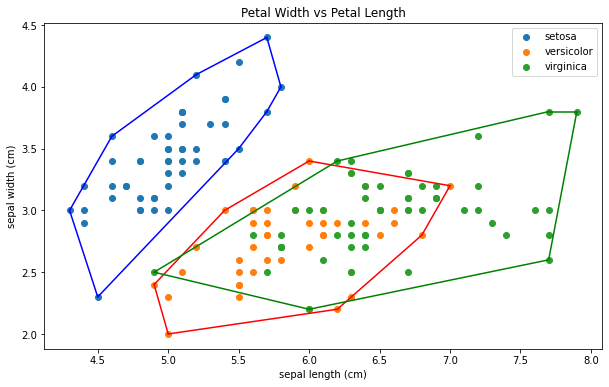

In [20]:
from scipy.spatial import ConvexHull
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i]
    bucket = bucket.iloc[:,[0,1]].values
    hull = KonvexHull(bucket)
    hull.my_convex_hull() #bagian ini diganti dengan hasil implementasi ConvexHull Divide & Conquer
    plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
    for simplex in hull.simplices:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.legend()
plt.show()